<a href="https://colab.research.google.com/github/ahshawaf/AML/blob/project6/Project6_Team1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://cdn.educba.com/academy/wp-content/uploads/2019/10/Unsupervised-Machine-Learning.jpg)

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets consisting of input data without labeled responses. The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data. Within this experiment, the datasets (image type) and machine learning techniques are described below.

**Image Datasets:**


*   Bridge: 4x4 pixel blocks of bridge images.   
http://cs.joensuu.fi/sipu/datasets/ 
*   Coil-100: The dataset contains 7200 color images of 100 objects (72 images per object)  
https://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php

*   Celeb: CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including, 10,177 number of identities, 202,599 number of face images, and 5 landmark locations, 40 binary attributes annotations per image.   
http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
*   ImageNet: Images are collected variously from internet, come with two resolutions, 32x32 and 64x64.   
http://image-net.org/small/download.php


**Machine Learning Techniques:** 


*   K-Means Clustering
*   RandomForest Classifier
*   GuassianMixture Classifier
*   Anomaly Detection Using GuassianMixture







#Setup

In [229]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(42)

from zipfile import ZipFile


from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

#Custom Functions

This is a fucntion to download a file using **URL**. Then save it in the **save_path** with **target_file_name**. If target_file_name is empty, then the file name will be gotten from the URL.

In [0]:
import urllib
import urllib.parse as parse

def download(url,save_path,target_file_name=''):
  print("file is being downloading from {} ...".format(url))
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path,target_file_name)
  with open(targetFile,'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

This is a function to extract tar file in the **tar_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractTar(tar_file_path,target_path):
    print("Extracting is starting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

This is a function to extract zip file in the **zip_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractZip(zip_file_path,target_path):
    print("Extracting is starting....")
    zFile=ZipFile(zip_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

This is a custom function to create a imgs set without labels, unsupervised dataset. It used the folder path of the imgs.

In [0]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path,img))
    img_imr = cv2.resize(img_imr,(32,32))
    x.append(np.array(img_imr))
  return x

randomly_sho_imgs is for randomly display nrows x ncols images from the training set 

In [0]:
def randomly_show_imgs(x_set,nrows,ncols):
  plt.figure(figsize=(10,10))
  for i in range(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    indx = random.randint(0,len(x_set))
    plt.imshow(x_set[indx])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
  plt.show()

plot_data is to generate a plot chart from the x data

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

plot_centroids to generate a plot chart with the centers point passed

In [0]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

plot_decision_boundaries is to generate a Voronoi diagram:

In [0]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plot_gaussian_mixture is to generate a plot chart for gaussian_mixture

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

create the following directeries to save the **downsampled and celeba datasets**

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

downsampled_path = os.path.join(root_path,'downsampled')
if not os.path.exists(downsampled_path):
  os.mkdir(downsampled_path)

celeba_path = os.path.join(root_path,'celeba')
if not os.path.exists(celeba_path):
  os.mkdir(celeba_path)

# Clustering Bridge Image Dataset

##Data Scrubing

## Loading Data

In [0]:
bridge = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/bridge.txt', delim_whitespace=True, header=None) #avoid spaces separated

In [241]:
bridge.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13   14   15
0   6   8   6   9   0   0   0   0   0   0   0   0   0   0    0    0
1   7   4   3   4   0   0   0   0   0   0   0   0   0   0    0    0
2   8   8   8  18  31  12  22  34  74  74  68  60  96  99  104   79
3   9   9  16  34  11  15  38  54  60  22  65  75  99  78   92  114
4   9  19  34  39  23  26  31  39  16  31  34  41  59  63   33   38

In [242]:
bridge.shape

(4096, 16)

In [243]:
bridge.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [0]:
bridge_np = np.array(bridge) #convert dataframe to numpy array

In [245]:
bridge_np

array([[  6,   8,   6, ...,   0,   0,   0],
       [  7,   4,   3, ...,   0,   0,   0],
       [  8,   8,   8, ...,  99, 104,  79],
       ...,
       [251, 247, 243, ..., 127, 141, 153],
       [252, 250, 249, ...,  92,  94,  99],
       [253, 224, 209, ..., 246, 233, 227]])

In [0]:
bridge4x4 = bridge_np.reshape(4096,4,4)

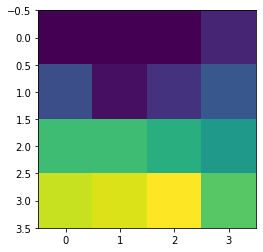

In [247]:
plt.imshow(bridge4x4[2]) #view the image index=2

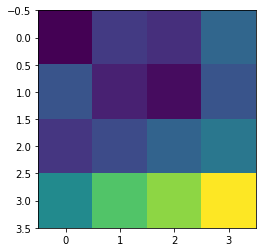

In [248]:
plt.imshow(bridge4x4[10]) #view the image index=10

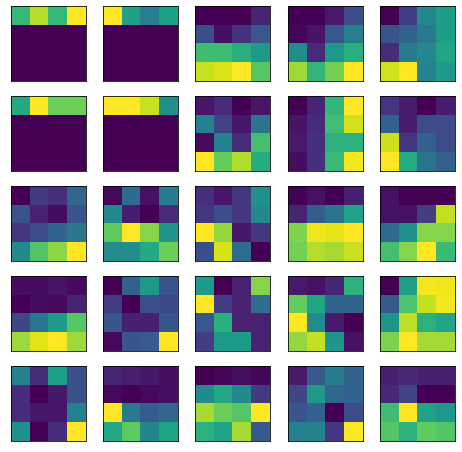

In [249]:
# See 25 images
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bridge4x4[i])

Text(0.5, 1.0, 'Bridge Dataset')

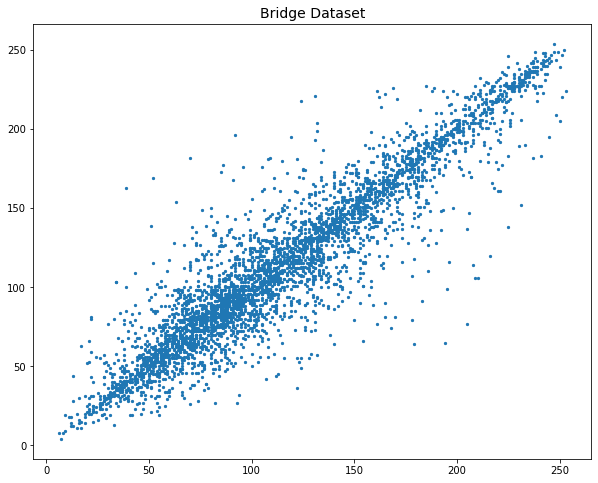

In [250]:
# See the whole dataset in 2d axis 
plt.figure(figsize=(10,8))
plt.scatter(bridge_np[:,0], bridge_np[:,1], s=5)
plt.title("Bridge Dataset", fontsize=14)

Generate isotropic Gaussian blobs for clustering

In [0]:
X_bridge, y_bridge = make_blobs(n_samples=len(bridge), random_state=42)

In [252]:
np.unique(y_bridge) #See how many labels was generated

array([0, 1, 2])

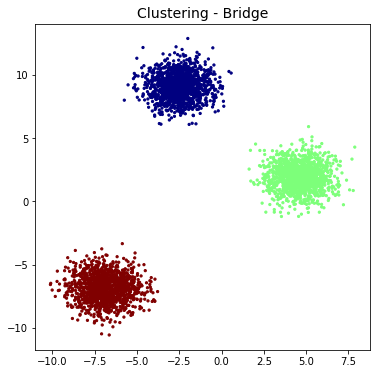

In [253]:
# Plot see the brief clusters 
plt.figure(figsize=(6,6))
plt.scatter(X_bridge[:, 0], X_bridge[:, 1], c=y_bridge, s=5, cmap='jet')
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

Therefore, the number of clusters should be 3.

##Plot K-Elbow

In [0]:
kmeans=[KMeans(n_clusters=k, random_state=42).fit(X_bridge) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans]

Text(0.5, 1.0, 'K - Elbow')

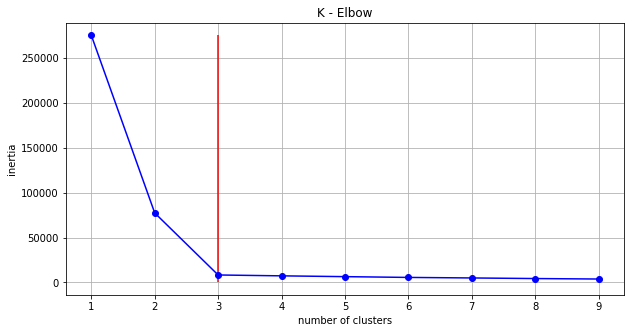

In [255]:
ax=plt.figure(figsize=(10,5))
plt.plot(range(1,10),inertias,"bo-")
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(3,0,np.max(inertias),color='red')
plt.title("K - Elbow")

As expected, the elbow point is k=3

## Plot the silhouette score vs performance of $k$

In [0]:
silhouette_scores = [silhouette_score(X_bridge, model.labels_)
                     for model in kmeans[1:]]
best_index = np.argmax(silhouette_scores)
best_score = silhouette_scores[best_index]
best_model = kmeans[best_index]

Text(0.5, 1.0, 'Performance of $K$')

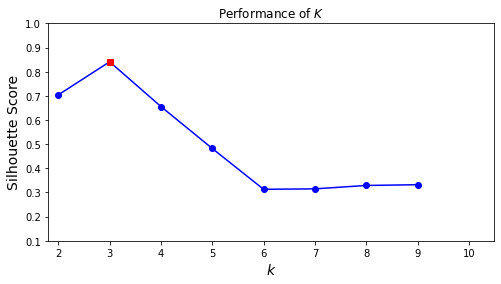

In [257]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.plot(3, best_score, "rs")
plt.axis([1.8, 10.5, 0.1, 1.0])
plt.title("Performance of $K$")

This visualization is clear to confirms that $k=3$ is the best choice.

## K-Means Clustering

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=3, random_state=42)

In [0]:
y = kmodel.fit_predict(X_bridge)

In [260]:
y

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

In [261]:
len(y)

4096

In [262]:
y is kmodel.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [263]:
kmodel.labels_

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

Of course, we can predict the labels of new instances:

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

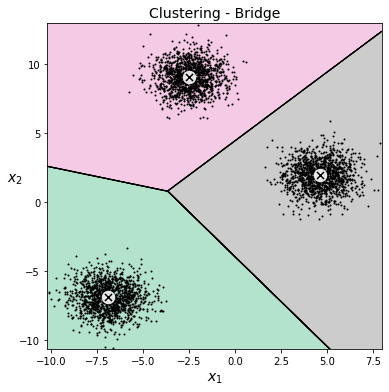

In [264]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmodel, X_bridge)
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_bridge_train, X_bridge_test, y_bridge_train, y_bridge_test = train_test_split(X_bridge, y, test_size=0.3, shuffle = True, random_state=42)

In [266]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((2867, 2), (1229, 2), (2867,), (1229,))

Create the model and fit with the training set

In [267]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_bridge_train, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [268]:
cross_val_score(RF_bridge, X_bridge_train[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

1.0

Test the model using testing set

In [269]:
RF_bridge.score(X_bridge_test, y_bridge_test)

1.0

See the predict score

In [270]:
y_pred = RF_bridge.predict(X_bridge)
y_pred

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

In [271]:
accuracy_score(y, y_pred)

1.0

See the confustion matrix

In [0]:
labels = ['0', '1', '2']

Text(0.5, 1.0, 'Confusion Matrix')

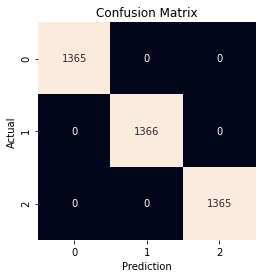

In [273]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

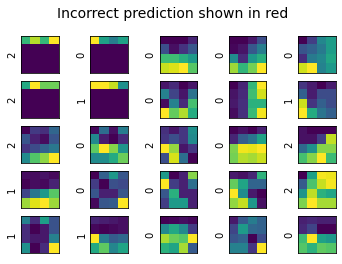

In [274]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(bridge4x4[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(labels[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_train_reduced = best_model.transform(X_bridge_train)
X_test_reduced = best_model.transform(X_bridge_test)

Perform cross validation using subset size 500

In [276]:
cross_val_score(RF_bridge, X_train_reduced[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.9020032224707212

Fit to training model

In [277]:
RF_bridge.fit(X_train_reduced, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [278]:
RF_bridge.score(X_test_reduced, y_bridge_test)

0.9023596419853539

The performance produce higher error when using K-Means as dimensionality reduction.

## Search for the number of clusters that provides the best performance.

In [279]:
from sklearn.pipeline import Pipeline

pipe_bridge_scores = []
for n_clusters in range(1,11):
    pipe_bridge = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe_bridge.fit(X_bridge_train, y_bridge_train)

    pipe_bridge_scores.append([])
    pipe_bridge_scores[n_clusters-1].append(n_clusters)
    score = pipe_bridge.score(X_bridge_test, y_bridge_test)
    pipe_bridge_scores[n_clusters-1].append(score)


    print(n_clusters, score)

1 0.6517493897477624
2 0.8966639544344996
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0


## This can be seen clearly that, n_clusters = 3 provides the best performance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(0.99)
X_bridge_pca = pca.fit_transform(X_bridge)

Let's train a Gaussian mixture model on the training set

In [281]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_bridge_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Let's look at the parameters that the EM algorithm estimated:

In [282]:
gm.weights_

array([0.33325195, 0.33349609, 0.33325195])

In [283]:
gm.means_

array([[ 9.76841849, -1.04822152],
       [-6.49080233, -4.23657971],
       [-3.27286099,  5.28790496]])

Did the algorithm actually converge?

In [284]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [285]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [286]:
gm.predict(X_bridge_pca)

array([2, 0, 0, ..., 2, 0, 0])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

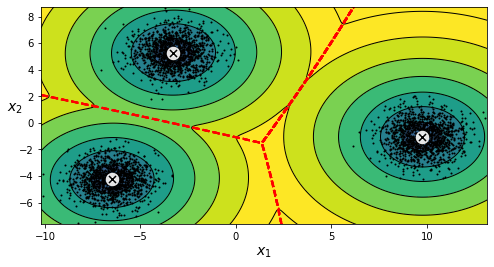

In [287]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_bridge_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(X_bridge_pca)
density_threshold = np.percentile(densities, 4)
anomalies = X_bridge_pca[densities < density_threshold]

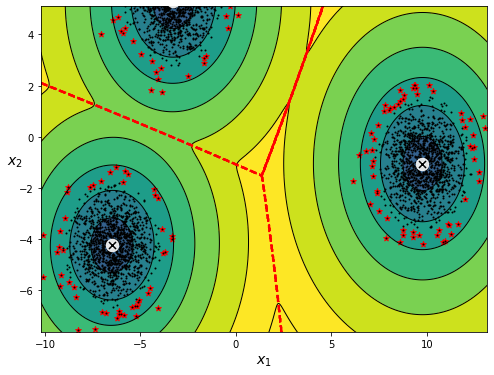

In [289]:
plt.figure(figsize=(8, 6))

plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Clustering Coil-100 Image Dataset

##Data Scrubing

## Loading Data

Download Coil100 from Sean Kaggle

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

In [291]:
download('https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586506868&Signature=OeomkNazrVOV6QMP6sd%2BMUJITjJSg0lk5tIpWhJOwU4c4VCK7E3PxxEKlovk4x8XBGKmtL90cQUy5BoQSo%2BdulwmSx41RqZYkRHPMyvhgydFX0wAol%2Fy75828DdowN37isM04sYFTD4PleKuj7hD95bFWvv1mKSh0w%2BIZAEaMsS6bOvqPpXkJYN1G8mffLUFWpKGklEX6Y4ERiMGhIlQBp9RH1WHAYSyoreld0g02%2FkrVzub8i%2B9D1sOPfG%2F8VfXgxyVoACA2lSRJycZ7me2wuAmBLx%2FlhivpHI2dLZ%2BBymxtmxhvDnDioxDl7wwQqYqy9MMUAlXPZPvlMJ%2Baf%2FaLQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip',os.path.join(root_path,'coil100'),'coil100.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586506868&Signature=OeomkNazrVOV6QMP6sd%2BMUJITjJSg0lk5tIpWhJOwU4c4VCK7E3PxxEKlovk4x8XBGKmtL90cQUy5BoQSo%2BdulwmSx41RqZYkRHPMyvhgydFX0wAol%2Fy75828DdowN37isM04sYFTD4PleKuj7hD95bFWvv1mKSh0w%2BIZAEaMsS6bOvqPpXkJYN1G8mffLUFWpKGklEX6Y4ERiMGhIlQBp9RH1WHAYSyoreld0g02%2FkrVzub8i%2B9D1sOPfG%2F8VfXgxyVoACA2lSRJycZ7me2wuAmBLx%2FlhivpHI2dLZ%2BBymxtmxhvDnDioxDl7wwQqYqy9MMUAlXPZPvlMJ%2Baf%2FaLQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip ...
Done, file in the path data/coil100/coil100.zip


In [292]:
extractZip('data/coil100/coil100.zip', 'data/coil100/imgs')

Extracting is starting....
Done


In [0]:
coil_100_lst = os.listdir('data/coil100/imgs/coil-100')

In [294]:
len(coil_100_lst)

7202

before deleteing none-image files the number of files are 7202 

In [295]:
# Remove files that are not image
for item in coil_100_lst:
    if not item.lower().endswith('.png'):
      path = os.path.join('data/coil100/imgs/coil-100', item)
      os.remove(path)
      print('Successfully deleted the file: {}'.format(path))

Successfully deleted the file: data/coil100/imgs/coil-100/convertGroupppm2png.pl~
Successfully deleted the file: data/coil100/imgs/coil-100/convertGroupppm2png.pl


after deleting the non-image files with total 2 files.

In [296]:
coil_100_lst = os.listdir('data/coil100/imgs/coil-100')
len(coil_100_lst)

7200

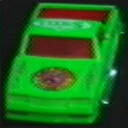

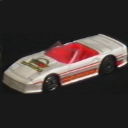

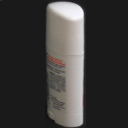

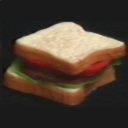

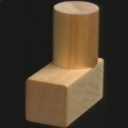

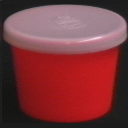

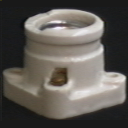

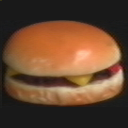

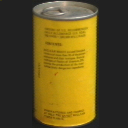

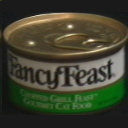

In [297]:
# Plot to see some images of the dataset
for i in range(10):
  rndIndx = random.randint(0,len(coil_100_lst)-1)
  img = cv2.imread(os.path.join('data/coil100/imgs/coil-100',coil_100_lst[rndIndx]))
  cv2_imshow(img)


Create the images dataset

In [0]:
coil_100=create_img_set(os.path.join('data/coil100/imgs/coil-100'))

Generate isotropic Gaussian blobs for clustering

In [0]:
X_coil100, y_coil100 = make_blobs(n_samples=len(coil_100), centers=100, random_state=42, )

In [300]:
X_coil100.shape, y_coil100.shape

((7200, 2), (7200,))

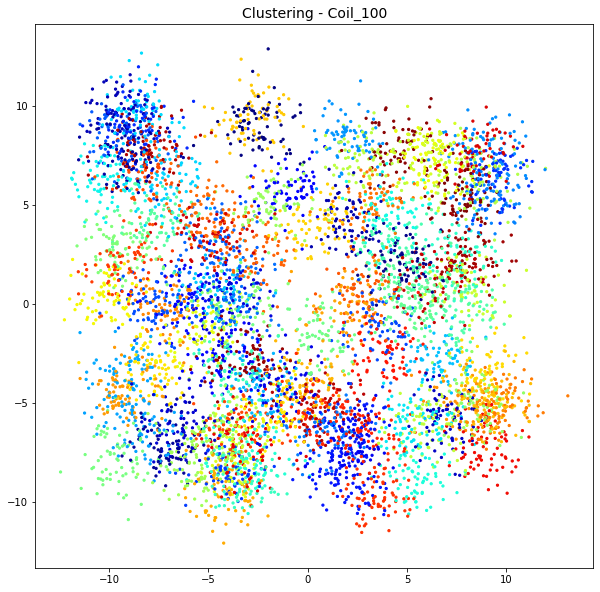

In [301]:
# Plot see the brief clusters 
plt.figure(figsize=(10,10))
plt.scatter(X_coil100[:, 0], X_coil100[:, 1], c=y_coil100, s=5, cmap='jet')
plt.title("Clustering - Coil_100", fontsize=14)
plt.show()

Therefore, the number of clusters should be 3.

##Plot K-Elbow

In [0]:
kmeans =[KMeans(n_clusters=k, random_state=42).fit(X_coil100) for k in range(10,150,10)]
inertias = [model.inertia_ for model in kmeans]

Text(0.5, 1.0, 'K - Elbow')

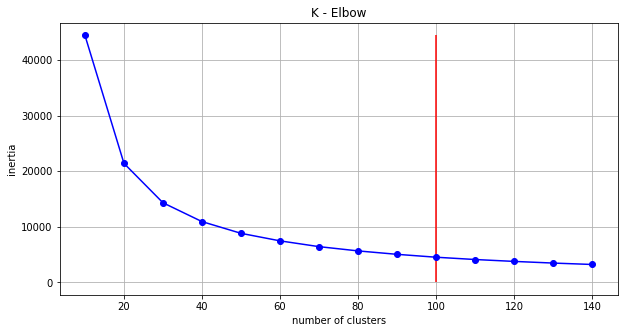

In [303]:
ax=plt.figure(figsize=(10,5))
plt.plot(range(10,150,10),inertias,"bo-")
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(100,0,np.max(inertias),color='red')
plt.title("K - Elbow")

###The elbow point is k=100

## K-Means Clustering

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=100, random_state=42)

In [0]:
y = kmodel.fit_predict(X_coil100)

In [306]:
y

array([51, 75, 94, ..., 47, 41, 55], dtype=int32)

In [307]:
len(y)

7200

In [308]:
y is kmodel.labels_

True

Therefore, y is the label (1, 2,..,100) tha represents for each cluster.

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

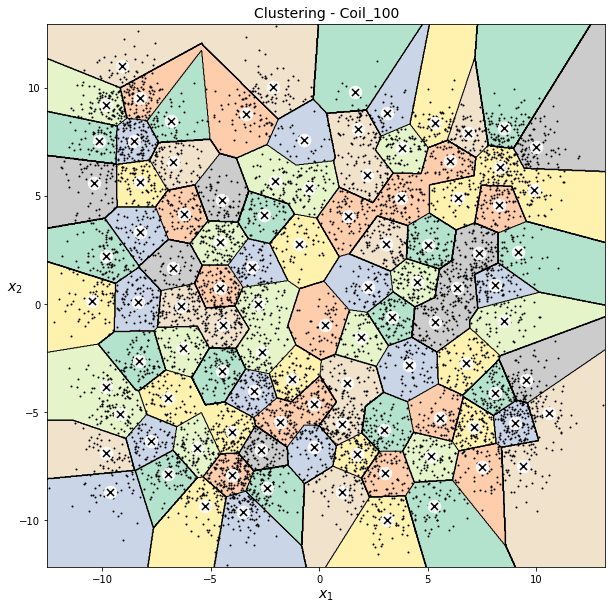

In [309]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(kmodel, X_coil100)
plt.title("Clustering - Coil_100", fontsize=14)
plt.show()

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_coil100_train, X_coil100_test, y_coil100_train, y_coil100_test = train_test_split(X_coil100, y, test_size=0.3, shuffle = True, random_state=42)

In [311]:
X_coil100_train.shape, X_coil100_test.shape, y_coil100_train.shape, y_coil100_test.shape

((5040, 2), (2160, 2), (5040,), (2160,))

Create the model and fit with the training set

In [312]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_coil100_train, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [313]:
cross_val_score(RF_bridge, X_coil100[:500], y[:500], cv=3, scoring='accuracy').mean()

0.7920664694706971

Test the model using testing set

In [314]:
RF_bridge.score(X_coil100_test, y_coil100_test)

0.9439814814814815

See the predict score

In [315]:
y_pred = RF_bridge.predict(X_coil100)
y_pred

array([51, 75, 94, ..., 47, 41, 55], dtype=int32)

In [316]:
accuracy_score(y, y_pred)

0.9831944444444445

See the confustion matrix

In [317]:
labels= np.unique(kmodel.labels_)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

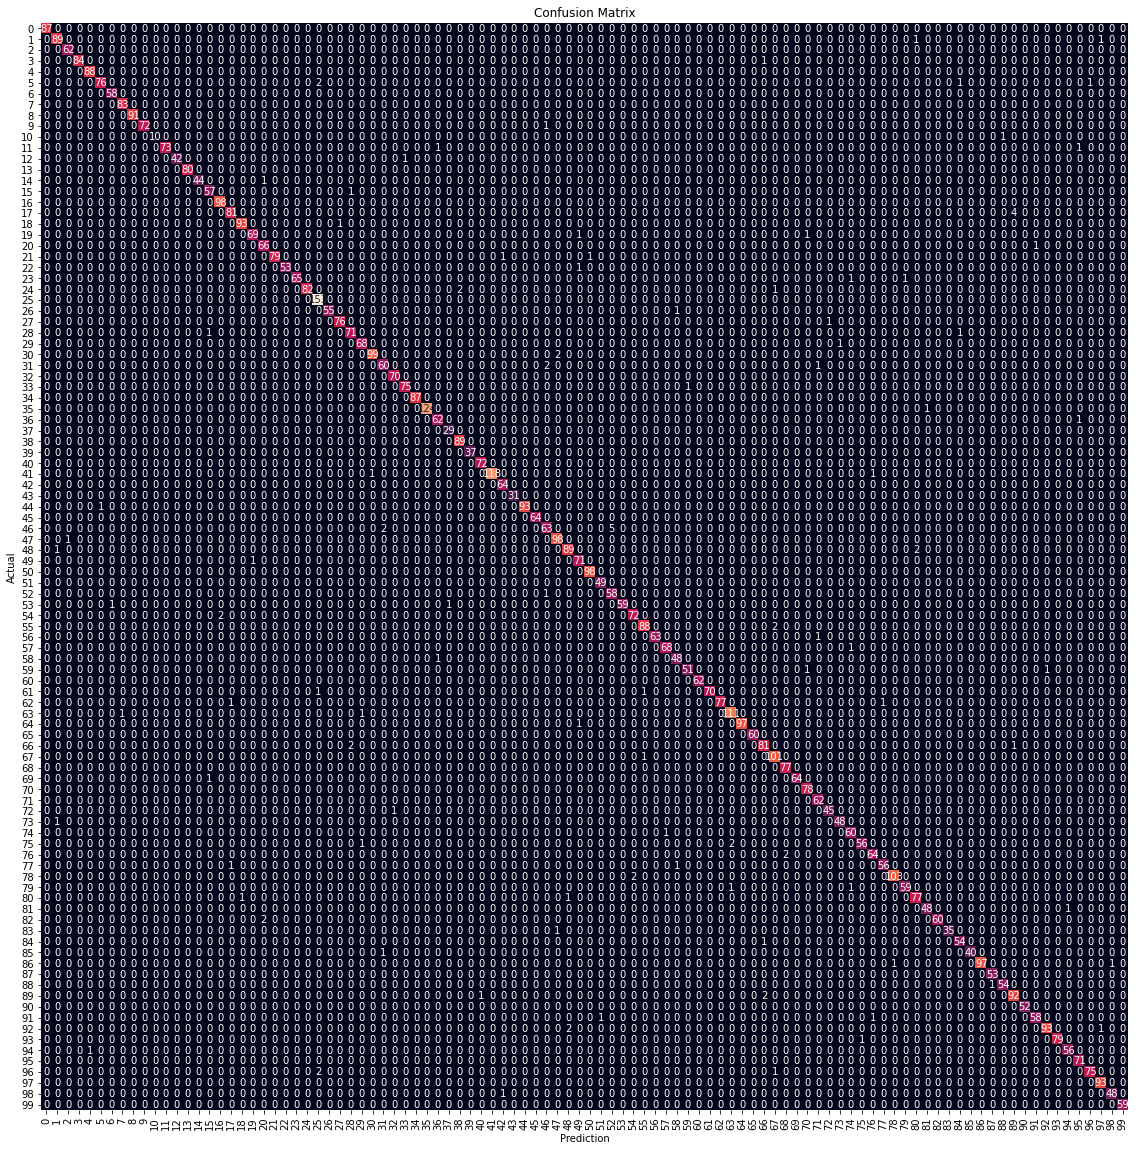

In [318]:
fig, ax = plt.subplots(figsize=(20,20)) 
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',
            cbar=False, ax=ax,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

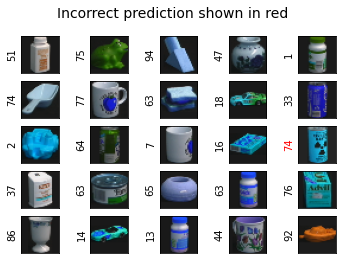

In [319]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(coil_100[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_train_coil100_reduced = best_model.transform(X_coil100_train)
X_test_coil100_reduced = best_model.transform(X_coil100_test)

Perform cross validation using subset size 500

In [321]:
cross_val_score(RF_bridge, X_train_coil100_reduced[:500], y_coil100_train[:500], cv=3, scoring='accuracy').mean()

0.5320804174782964

Fit to training model

In [322]:
RF_bridge.fit(X_train_coil100_reduced, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [323]:
RF_bridge.score(X_test_coil100_reduced, y_coil100_test)

0.6773148148148148

The performance produce higher error when using K-Means as dimensionality reduction.

## Search for the number of clusters that provides the best performance.

In [327]:
from sklearn.pipeline import Pipeline

pipe_coil100_scores = []
indx = 0
for n_clusters in range(10,150,10):
    pipe = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe.fit(X_coil100_train, y_coil100_train)

    pipe_coil100_scores.append([])
    pipe_coil100_scores[indx].append(n_clusters)
    score = pipe.score(X_coil100_test, y_coil100_test)
    pipe_coil100_scores[indx].append(score)
    indx = indx + 1
    
    print(n_clusters, score)

10 0.9564814814814815
20 0.9648148148148148
30 0.9606481481481481
40 0.9648148148148148
50 0.9648148148148148
60 0.9657407407407408
70 0.9662037037037037
80 0.9643518518518519
90 0.9694444444444444
100 0.9680555555555556
110 0.9625
120 0.9657407407407408
130 0.9652777777777778
140 0.9685185185185186


### All n_clusters provides similar erformance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(0.99)
X_pca = pca.fit_transform(X_coil100)

Let's train a Gaussian mixture model on the training set

In [98]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=100, n_init=10, random_state=42)
gm.fit(X_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=100, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [99]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [100]:
gm.n_iter_

9

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [101]:
gm.predict(X_pca)

array([51, 82, 68, ..., 19, 70, 90])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

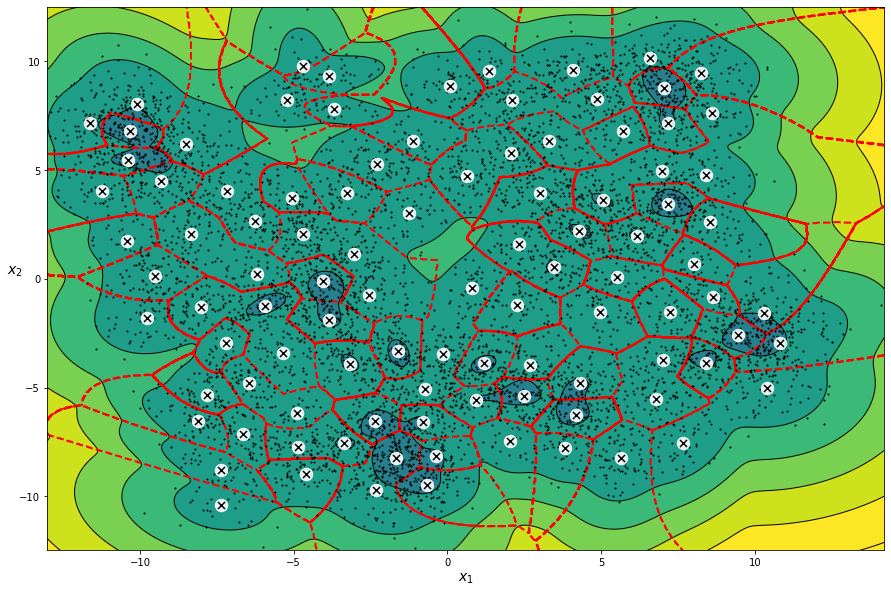

In [103]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm, X_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Assume the threshold is 10%

In [0]:
densities = gm.score_samples(X_pca)
density_threshold = np.percentile(densities, 10)
anomalies = X_pca[densities < density_threshold]

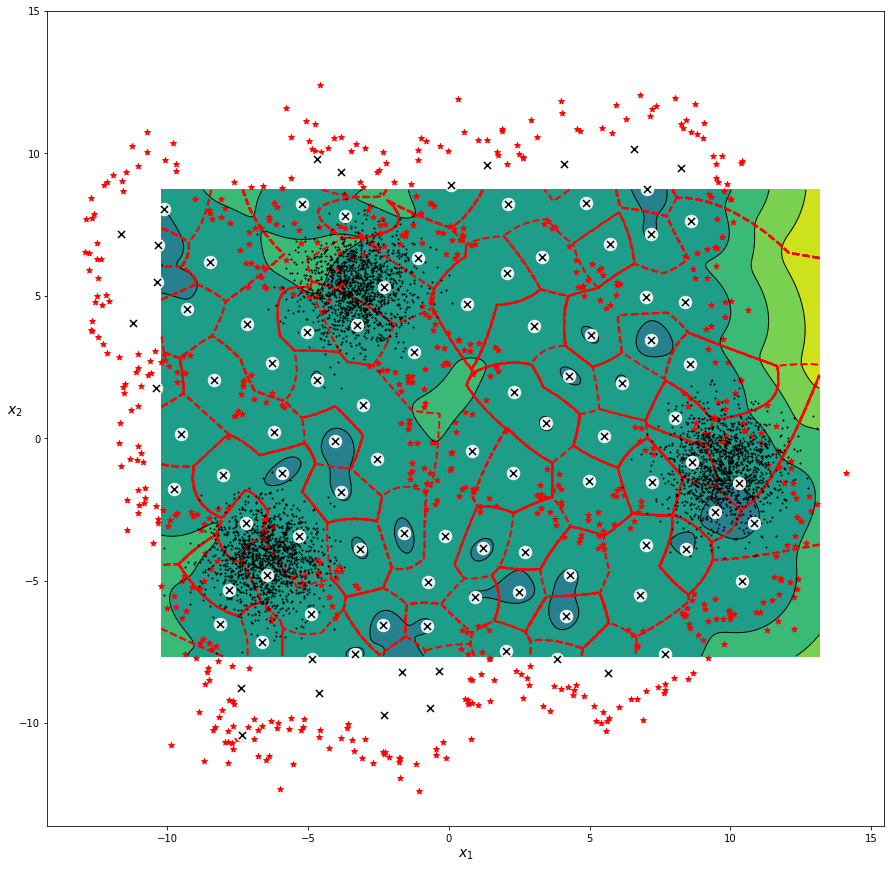

In [105]:
plt.figure(figsize=(15, 15))

plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=15)
plt.show()

#Celeba Dataset

##Loading Downsampled Dataset

here, the celeba data will be downloaded to the path 'data/celeba'



In [106]:
url = 'https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586578463&Signature=MpjyYG9vibDTKL%2BL8llqi9%2Fbnk0JDjDSGv8%2B7XFCjIzKYGtb0n6XPDK30ppsXQo4PrmYGNKdhpSGDqPDZATtXDntrQnmnaIO%2BnNUj8Zan6rCnRd1rYEFqKFE3%2B2a85njQY97bbFr4A%2FYZ3GslMhL53%2BVGp1%2F5RM92Gdl2%2FVjyB%2BAfZKzqzCZsb9jALLLK6vUfZI4Ltc2qiCId%2BOc%2B%2FfP8RUAOFA7Z5Qebms%2BgudRNSb9a61l%2FeaH9iXrXZG5RSmJEFUmorkuOoRXrXIodbb96HFCJ%2BiD5JfXB43Rcl3CHagokBPr3joXLIujxm9nDL%2BF2U7qBE5gVSQf1aY06q%2FVHA%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip'
save_path = celeba_path
download(url,save_path=save_path,target_file_name='celeba.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586578463&Signature=MpjyYG9vibDTKL%2BL8llqi9%2Fbnk0JDjDSGv8%2B7XFCjIzKYGtb0n6XPDK30ppsXQo4PrmYGNKdhpSGDqPDZATtXDntrQnmnaIO%2BnNUj8Zan6rCnRd1rYEFqKFE3%2B2a85njQY97bbFr4A%2FYZ3GslMhL53%2BVGp1%2F5RM92Gdl2%2FVjyB%2BAfZKzqzCZsb9jALLLK6vUfZI4Ltc2qiCId%2BOc%2B%2FfP8RUAOFA7Z5Qebms%2BgudRNSb9a61l%2FeaH9iXrXZG5RSmJEFUmorkuOoRXrXIodbb96HFCJ%2BiD5JfXB43Rcl3CHagokBPr3joXLIujxm9nDL%2BF2U7qBE5gVSQf1aY06q%2FVHA%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip ...
Done, file in the path data/celeba/celeba.zip


Extract the celeba  dataset to the path data/celeba/imgs/

In [107]:
extractZip(os.path.join(celeba_path,'celeba.zip'),os.path.join(celeba_path,'imgs'))

Extracting is starting....
Done


##Exploring Data 

list randomly 10 images of the training data

In [108]:
main_path = os.path.join(celeba_path,'imgs/img_align_celeba')

clb_lst=os.listdir(main_path)
len(clb_lst)

202599

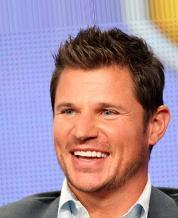

image size (218, 178, 3) 


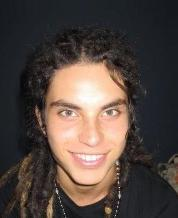

image size (218, 178, 3) 


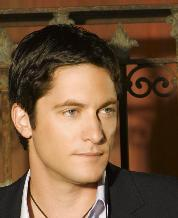

image size (218, 178, 3) 


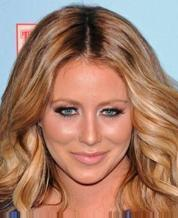

image size (218, 178, 3) 


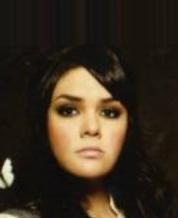

image size (218, 178, 3) 


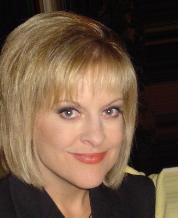

image size (218, 178, 3) 


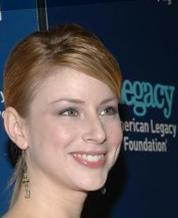

image size (218, 178, 3) 


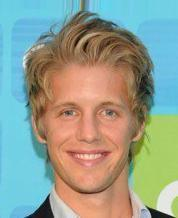

image size (218, 178, 3) 


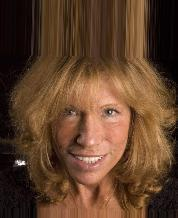

image size (218, 178, 3) 


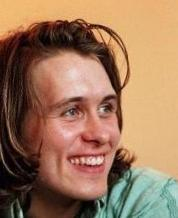

image size (218, 178, 3) 


In [109]:
for i in range(10):
  rndIndx=random.randint(0,len(clb_lst)-1)
  imgPath = os.path.join(main_path,clb_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

##Creating Training Set

In [0]:
celeba_imgs_folder_path = os.path.join(celeba_path,'imgs/img_align_celeba')
clb_x= create_img_set(celeba_imgs_folder_path)

In [111]:
len(clb_x)

202599

Show randomly 25 images from the training set

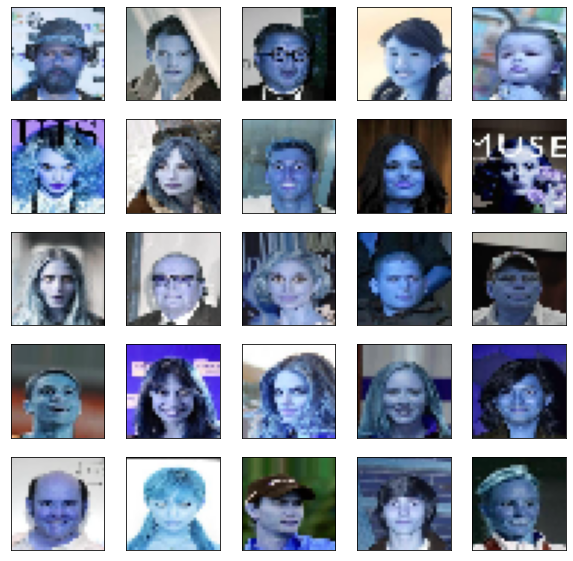

In [112]:
randomly_show_imgs(clb_x,5,5)

##Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
clb_x_npa = np.array(clb_x)

In [114]:
clb_x_npa.shape

(202599, 32, 32, 3)

Convert the data from (202599, 32, 32, 3) to (202599, 3072) which is (202599, 32x32x3)

In [0]:
rows=int(clb_x_npa.shape[0])
cols=int(clb_x_npa.shape[1]*clb_x_npa.shape[2]*clb_x_npa.shape[3])
clb_x_npa=clb_x_npa.reshape(rows,cols)

In [116]:
clb_x_npa.shape

(202599, 3072)

##Clustring

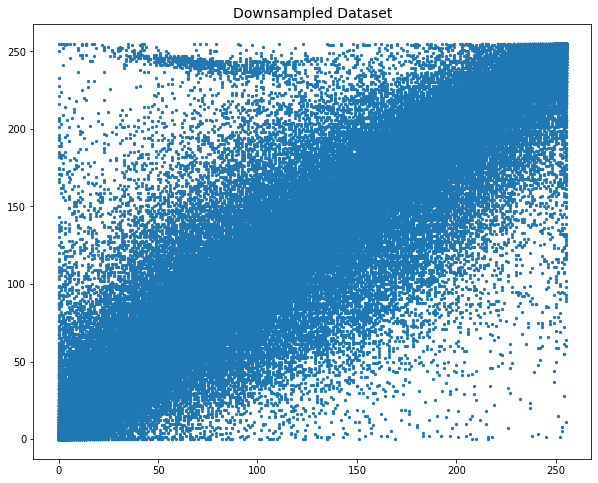

In [117]:
plt.figure(figsize=(10,8))
plt.scatter(clb_x_npa[:,0],clb_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

Creatgin blobs samples

In [0]:
clb_x_blob, clb_y_blob=make_blobs(n_samples=len(clb_x_npa),random_state=47,centers=8)

Display the distinct labels

In [119]:
np.unique(clb_y_blob)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [120]:
clb_y_blob.shape

(202599,)

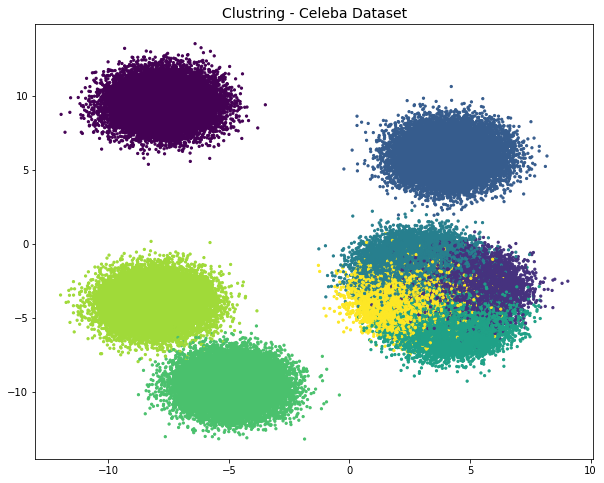

In [121]:
plt.figure(figsize=(10,8))
plt.scatter(clb_x_blob[:,0],clb_x_blob[:,1],c=clb_y_blob,s=5)
plt.title('Clustring - Celeba Dataset',fontsize = 14)
plt.show()

##Plot K-elbow

Using a subset with 10,000 rows for running fast as the entire data is 202,599 which is huge. It takes long time to excute the code


In [0]:
clb_range=range(1,10)
clb_kmeans=[KMeans(n_clusters=k,random_state=47).fit(clb_x_blob[:10000]) for k in clb_range]
inertias = [model.inertia_ for model in clb_kmeans]

Text(0.5, 1.0, 'K - Elbow for Celeba')

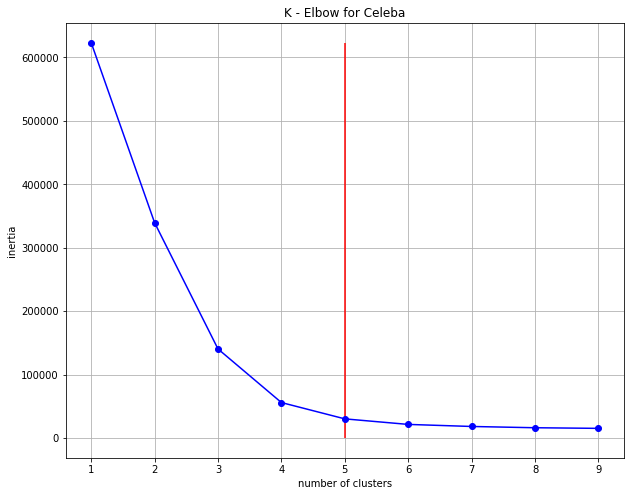

In [123]:
plt.figure(figsize=(10,8))
plt.plot(clb_range,inertias,'bo-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(5,0,np.max(inertias),color='red')
plt.title("K - Elbow for Celeba")

from the elbow chart, the number of cluster is 3 is most suitable.

##Plot the silhouette score vs performance of k

In [0]:
clb_silhouette_score= [silhouette_score(clb_x_blob[:10000],model.labels_) for model in clb_kmeans[1:]]
clb_best_indx = np.argmax(clb_silhouette_score)
clb_best_score = clb_silhouette_score[clb_best_indx]
clb_best_model = clb_kmeans[1:][clb_best_indx]

because the clb_kmeans is passed starting from index 1 not zero. Also, the resturn index for clb_best_indx starts from 0. So, 2 is added to the index

In [0]:
clb_number_of_cluster = clb_best_indx + 2

Text(0.5, 1.0, 'Performance of $K$ for Celeba')

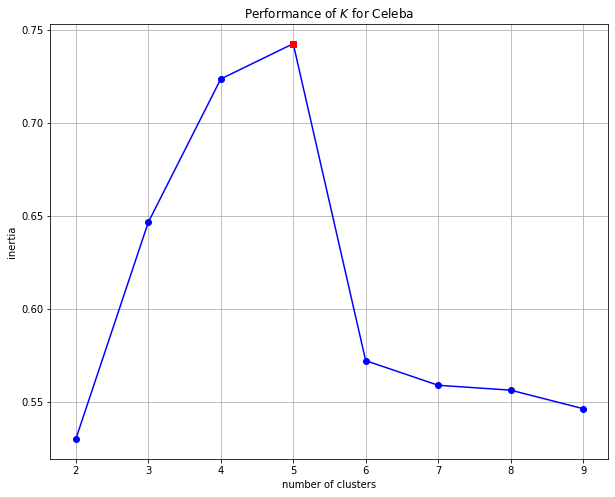

In [126]:
plt.figure(figsize=(10,8))
plt.plot(range(2,10),clb_silhouette_score,'bo-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.plot(clb_number_of_cluster,clb_best_score,'rs')
plt.title("Performance of $K$ for Celeba")

This visualization is clear to confirms that $k=5$ is the best choice.

##K-Means Clustering



###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=5, random_state=42)

In [0]:
y = kmodel.fit_predict(clb_x_blob)

In [129]:
y

array([1, 1, 2, ..., 2, 4, 2], dtype=int32)

In [130]:
np.unique(y)

array([0, 1, 2, 3, 4], dtype=int32)

In [131]:
len(y)

202599

In [132]:
y is kmodel.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

Note that the KMeans instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to:

In [133]:
kmodel.labels_

array([1, 1, 2, ..., 2, 4, 2], dtype=int32)

Of course, we can predict the labels of new instances:

###Decision Boundaries


Let's plot the model's decision boundaries. This gives us a Voronoi diagram

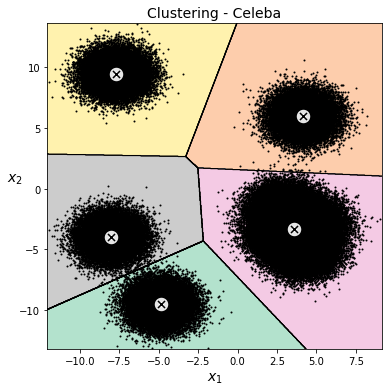

In [134]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmodel, clb_x_blob)
plt.title("Clustering - Celeba", fontsize=14)
plt.show()

##With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
clb_x_train, clb_x_test, clb_y_train, clb_y_test = train_test_split(clb_x_blob, y, test_size=0.3, shuffle = True, random_state=42)

In [136]:
clb_x_train.shape, clb_y_train.shape, clb_x_test.shape, clb_y_test.shape

((141819, 2), (141819,), (60780, 2), (60780,))


Create the model and fit with the training set

In [137]:
from sklearn.ensemble import RandomForestClassifier

RF_clb = RandomForestClassifier(random_state=42)
RF_clb.fit(clb_x_train, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [138]:
cross_val_score(RF_clb, clb_x_test, clb_y_test, cv=3, scoring='accuracy').mean()

0.9997532082922014

Test the model using testing set

In [139]:
RF_clb.score(clb_x_test, clb_y_test)

0.9998519249753208

See the predict score

In [140]:
y_pred = RF_clb.predict(clb_x_blob)
y_pred

array([1, 1, 2, ..., 2, 4, 2], dtype=int32)

In [141]:
accuracy_score(y, y_pred)

0.9999555772733331

See the confustion matrix

In [142]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1, 2, 3, 4], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

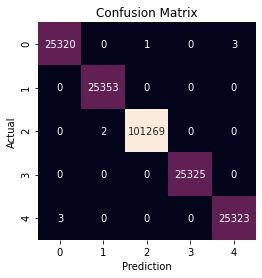

In [143]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

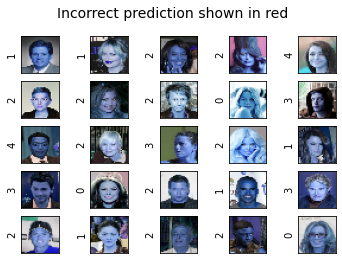

In [144]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(clb_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);


There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
X_train_reduced = clb_best_model.transform(clb_x_train)
X_test_reduced = clb_best_model.transform(clb_x_test)

In [146]:
X_train_reduced.shape,X_test_reduced.shape

((141819, 5), (60780, 5))

Perform cross validation using subset size 500

In [147]:
cross_val_score(RF_clb, clb_x_test[:500], clb_y_test[:500], cv=3, scoring='accuracy').mean()

1.0


Fit to training model

In [148]:
RF_clb.fit(X_train_reduced, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [149]:
RF_clb.score(X_test_reduced, clb_y_test)

0.9999177360974004

The accuracy is same with reduction or not

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(n_components=0.99)
X_clb_pca = pca.fit_transform(clb_x_npa)

In [151]:
X_clb_pca.shape

(202599, 944)

In [0]:
pca = PCA(n_components=0.95)
X_clb_pca = pca.fit_transform(clb_x_npa)

In [153]:
X_clb_pca.shape

(202599, 363)

Let's train a Gaussian mixture model on the training set

In [154]:

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, n_init=10, random_state=42)
gm.fit(clb_x_blob)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


Let's look at the parameters that the EM algorithm estimated:

In [155]:
gm.weights_

array([0.12499788, 0.12493879, 0.50005952, 0.12500062, 0.12500319])

In [156]:
gm.means_

array([[-4.87204032, -9.52472407],
       [ 4.15227855,  5.99841158],
       [ 3.61081211, -3.32411277],
       [-7.72249479,  9.48974757],
       [-8.03208163, -3.99505385]])

Did the algorithm actually converge?

In [157]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [158]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [159]:
gm.predict(clb_x_blob)

array([1, 1, 2, ..., 2, 4, 2])


Now let's plot the resulting decision boundaries (dashed lines) and density contours:

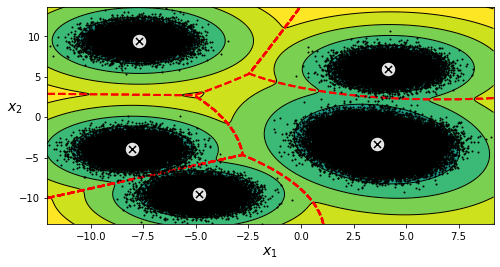

In [160]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, clb_x_blob)
plt.show()

##Search for the number of clusters that provides the best performance.

In [161]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_clb_scores = []
for n_clusters in range(1,11):
    pipe_clb = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_clb.fit(clb_x_train, clb_y_train)

    pipe_clb_scores.append([])
    pipe_clb_scores[n_clusters-1].append(n_clusters)
    score = pipe_clb.score(clb_x_test, clb_y_test)
    pipe_clb_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)

1 0.7227048371174728
2 0.9802073050345509
3 0.9997696610727212
4 0.9998025666337611
5 0.9999177360974004
6 0.9999341888779204
7 0.9999341888779204
8 0.9999670944389601
9 0.9999012833168806
10 0.9998848305363607



This can be seen clearly that, n_clusters = 5 provides the best performance.

##Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(clb_x_blob)
density_threshold = np.percentile(densities, 4)
anomalies = clb_x_blob[densities < density_threshold]

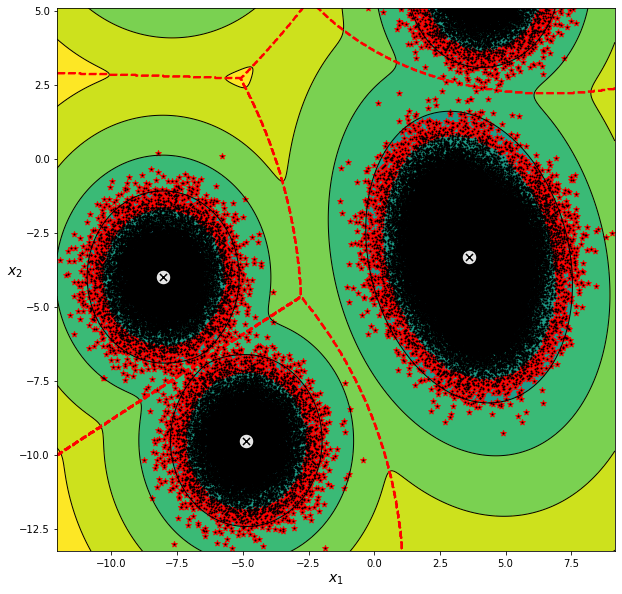

In [163]:
plt.figure(figsize=(10, 10))

plot_gaussian_mixture(gm, clb_x_blob)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

#Downsampled Dataset

##Loading Downsampled Dataset

here, the downsampled dataset will be downloaded using the custom function download using the URL http://image-net.org/small/train_32x32.tar which is the training set. For the validation test the URL is http://image-net.org/small/valid_32x32.tar

Downsampled source website: http://image-net.org/small/download.php




In [164]:
url = 'http://image-net.org/small/train_32x32.tar'
save_path = downsampled_path
download(url,save_path=save_path)

file is being downloading from http://image-net.org/small/train_32x32.tar ...
Done, file in the path data/downsampled/train_32x32.tar


Extract the train_32x32 dataset to the path data/downsampled/imgs/

In [165]:
extractTar(os.path.join(downsampled_path,'train_32x32.tar'),os.path.join(downsampled_path,'imgs'))

Extracting is starting....
Done


##Exploring Data 

list randomly 10 images of the training data

In [166]:
main_path = os.path.join(downsampled_path,'imgs/train_32x32/')

dsp_lst=os.listdir(main_path)
len(dsp_lst)

1281149

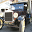

image size (32, 32, 3) 


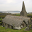

image size (32, 32, 3) 


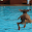

image size (32, 32, 3) 


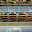

image size (32, 32, 3) 


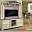

image size (32, 32, 3) 


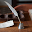

image size (32, 32, 3) 


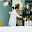

image size (32, 32, 3) 


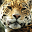

image size (32, 32, 3) 


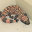

image size (32, 32, 3) 


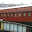

image size (32, 32, 3) 


In [167]:
for i in range(10):
  rndIndx=random.randint(0,len(dsp_lst)-1)
  imgPath = os.path.join(main_path,dsp_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

##Creating Training Set

In [0]:
downsampled_imgs_folder_path = os.path.join(downsampled_path,'imgs/train_32x32')
dsp_x= create_img_set(downsampled_imgs_folder_path)

In [169]:
len(dsp_x)

1281149

Show randomly 25 images from the training set

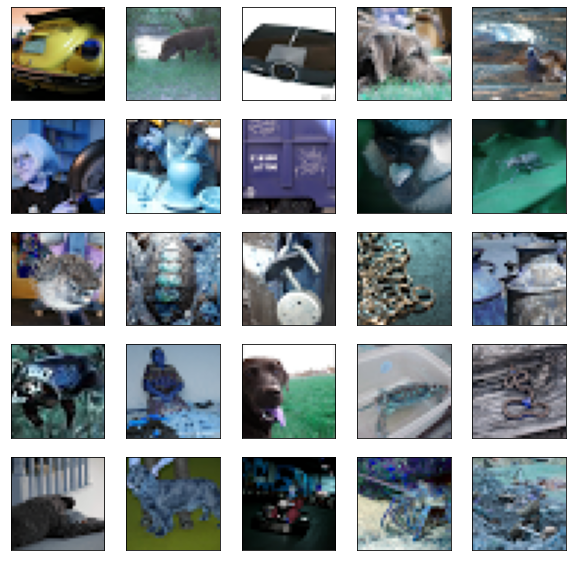

In [170]:
randomly_show_imgs(dsp_x,5,5)

##Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
dsp_x_npa = np.array(dsp_x)

In [172]:
dsp_x_npa.shape

(1281149, 32, 32, 3)

Convert the data from (1281149, 32, 32, 3) to (1281149, 3072) which is (1281149, 32x32x3)

In [0]:
rows=int(dsp_x_npa.shape[0])
cols=int(dsp_x_npa.shape[1]*dsp_x_npa.shape[2]*dsp_x_npa.shape[3])
dsp_x_npa=dsp_x_npa.reshape(rows,cols)

In [174]:
dsp_x_npa.shape

(1281149, 3072)

##Clustring

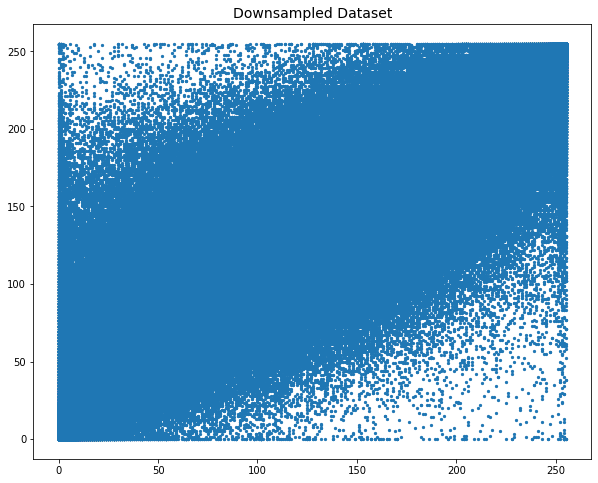

In [175]:
plt.figure(figsize=(10,8))
plt.scatter(dsp_x_npa[:,0],dsp_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

Creatgin blobs samples

In [0]:
dsp_x_blob, dsp_y_blob=make_blobs(n_samples=len(dsp_x_npa),random_state=47,centers=100)

Display the distinct labels

In [177]:
np.unique(dsp_y_blob)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [178]:
dsp_y_blob.shape

(1281149,)

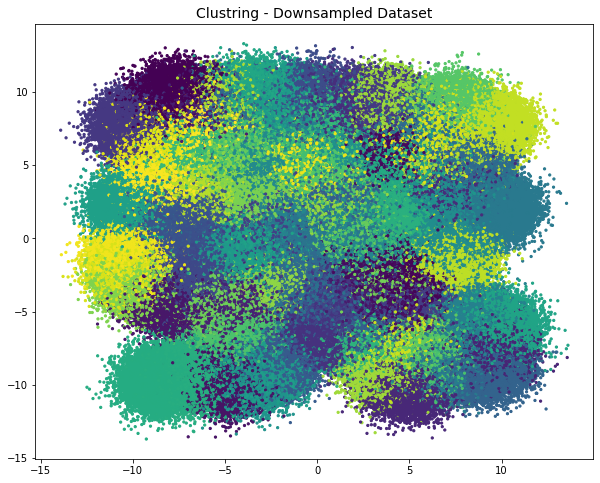

In [179]:
plt.figure(figsize=(10,8))
plt.scatter(dsp_x_blob[:,0],dsp_x_blob[:,1],c=dsp_y_blob,s=5)
plt.title('Clustring - Downsampled Dataset',fontsize = 14)
plt.show()

##Plot K-elbow

Using a subset with 10,000 rows for running fast as the entire data is 1,281,149 which is huge. It takes long time to excute the code

In [0]:
dsp_range=range(1,50)
dsp_kmeans=[KMeans(n_clusters=k,random_state=47).fit(dsp_x_blob[:10000]) for k in dsp_range]
inertias = [model.inertia_ for model in dsp_kmeans]

Text(0.5, 1.0, 'K - Elbow for Downsampled')

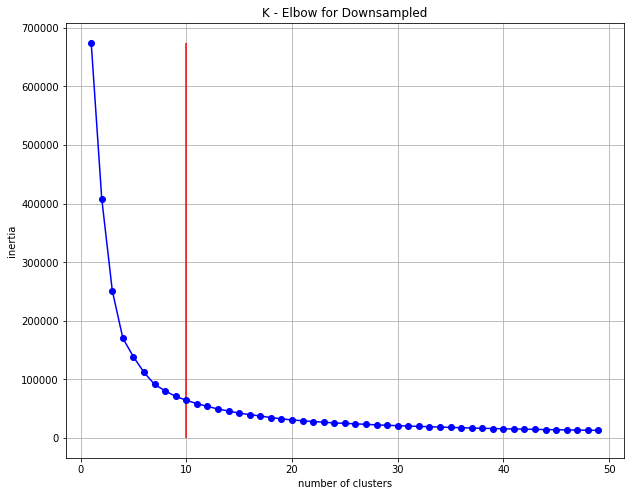

In [181]:
plt.figure(figsize=(10,8))
plt.plot(dsp_range,inertias,'bo-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(10,0,np.max(inertias),color='red')
plt.title("K - Elbow for Downsampled")

from the elbow chart, the number of cluster is 10 is most suitable.

##Plot the silhouette score vs performance of k

In [0]:
dsp_silhouette_score= [silhouette_score(dsp_x_blob[:10000],model.labels_) for model in dsp_kmeans[1:]]
dsp_best_indx = np.argmax(dsp_silhouette_score)
dsp_best_score = dsp_silhouette_score[dsp_best_indx]
dsp_best_model = dsp_kmeans[1:][dsp_best_indx]

because the clb_kmeans is passed starting from index 1 not zero. Also, the resturn index for clb_best_indx starts from 0. So, 2 is added to the index

In [0]:
dsp_number_of_cluster = dsp_best_indx + 2

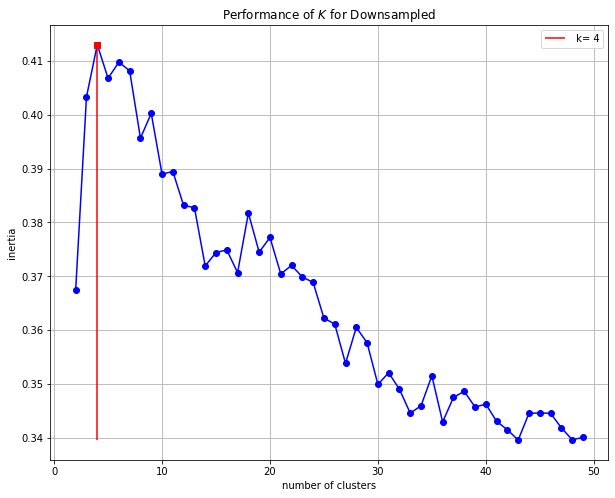

In [184]:
plt.figure(figsize=(10,8))
plt.plot(range(2,50),dsp_silhouette_score,'bo-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.plot(dsp_number_of_cluster,dsp_best_score,'rs')
plt.vlines(dsp_number_of_cluster,np.min(dsp_silhouette_score),dsp_best_score,color='red',label=' k= {}'.format(dsp_number_of_cluster))
plt.title("Performance of $K$ for Downsampled")
plt.legend()
plt.show()

This visualization shows the best k is 4 as it has the heighest silhouette score. However, from the elbow chart we can say the k = 10 is a proper choice

##K-Means Clustering



###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=10, random_state=42)

In [0]:
y = kmodel.fit_predict(dsp_x_blob[:10000])

In [187]:
y

array([4, 8, 8, ..., 9, 1, 0], dtype=int32)

In [188]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [189]:
len(y)

10000

In [190]:
y is kmodel.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

Note that the KMeans instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to:

In [191]:
kmodel.labels_

array([4, 8, 8, ..., 9, 1, 0], dtype=int32)

Of course, we can predict the labels of new instances:

###Decision Boundaries


Let's plot the model's decision boundaries. This gives us a Voronoi diagram

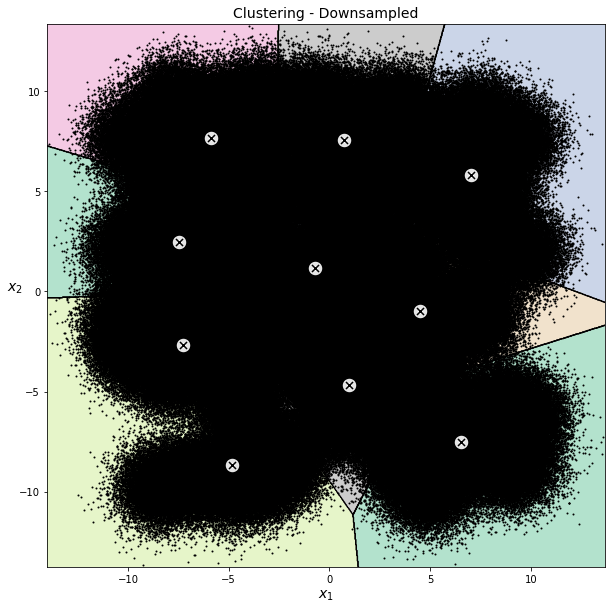

In [192]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(kmodel, dsp_x_blob)
plt.title("Clustering - Downsampled", fontsize=14)
plt.show()

##With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
dsp_x_train, dsp_x_test, dsp_y_train, dsp_y_test = train_test_split(dsp_x_blob[:10000], y, test_size=0.3, shuffle = True, random_state=42)

In [194]:
dsp_x_train.shape, dsp_y_train.shape, dsp_x_test.shape, dsp_y_test.shape

((7000, 2), (7000,), (3000, 2), (3000,))


Create the model and fit with the training set

In [195]:
from sklearn.ensemble import RandomForestClassifier

RF_dsp = RandomForestClassifier(random_state=42)
RF_dsp.fit(dsp_x_train, dsp_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [196]:
cross_val_score(RF_dsp, dsp_x_test, dsp_y_test, cv=3, scoring='accuracy').mean()

0.977

Test the model using testing set

In [197]:
RF_dsp.score(dsp_x_test, dsp_y_test)

0.9876666666666667

See the predict score

In [198]:
y_pred = RF_dsp.predict(dsp_x_blob[:10000])
y_pred

array([4, 8, 8, ..., 9, 1, 0], dtype=int32)

In [199]:
accuracy_score(y, y_pred)

0.9963

See the confustion matrix

In [200]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

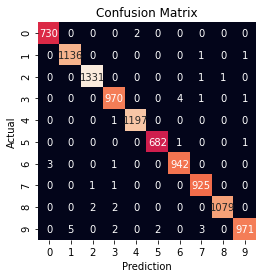

In [201]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

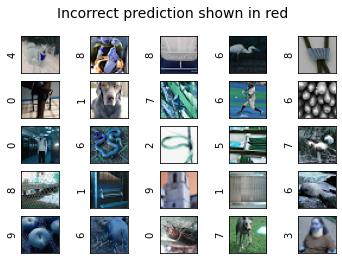

In [202]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(dsp_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);


There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
X_train_reduced = dsp_best_model.transform(dsp_x_train)
X_test_reduced = dsp_best_model.transform(dsp_x_test)

In [204]:
X_train_reduced.shape,X_test_reduced.shape

((7000, 4), (3000, 4))

Perform cross validation using subset size 500

In [205]:
cross_val_score(RF_dsp, dsp_x_test[:500], dsp_y_test[:500], cv=3, scoring='accuracy').mean()

0.9399273741673281


Fit to training model

In [206]:
RF_dsp.fit(X_train_reduced, dsp_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [207]:
RF_dsp.score(X_test_reduced, dsp_y_test)

0.9866666666666667

The accuracy is same with reduction or not

##Search for the number of clusters that provides the best performance.

In [208]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_dsp_scores = []
for n_clusters in range(1,11):
    pipe_dsp = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_dsp.fit(dsp_x_train, dsp_y_train)

    pipe_dsp_scores.append([])
    pipe_dsp_scores[n_clusters-1].append(n_clusters)
    score = pipe_dsp.score(dsp_x_test, dsp_y_test)
    pipe_dsp_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)

1 0.22566666666666665
2 0.6926666666666667
3 0.9893333333333333
4 0.9876666666666667
5 0.991
6 0.9896666666666667
7 0.988
8 0.989
9 0.9886666666666667
10 0.989



This can be seen clearly that, n_clusters = 5 provides the best performance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(n_components=0.99)
X_dsp_pca = pca.fit_transform(dsp_x_npa[:10000])

In [210]:
X_dsp_pca.shape

(10000, 1123)

Let's train a Gaussian mixture model on the training set

In [211]:

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=10, n_init=10, random_state=42)
gm.fit(dsp_x_blob)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


Let's look at the parameters that the EM algorithm estimated:

In [212]:
gm.weights_

array([0.12700681, 0.09127961, 0.09579418, 0.09418668, 0.10151244,
       0.03900216, 0.06783915, 0.11910381, 0.14667049, 0.11760467])

In [213]:
gm.means_

array([[ 6.60020767,  6.15477386],
       [-2.72023123, -0.62511874],
       [ 0.62280827,  7.71863291],
       [ 2.07376759,  1.12549694],
       [ 6.64498391, -7.7062495 ],
       [ 7.50861418,  0.12135805],
       [-4.50630967, -8.84184743],
       [ 2.10105515, -4.41319648],
       [-5.93463153,  6.96751524],
       [-7.92047822, -0.99338059]])

Did the algorithm actually converge?

In [214]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [215]:
gm.n_iter_

10

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.


In [216]:
gm.predict(dsp_x_blob)

array([8, 2, 2, ..., 9, 7, 7])


Now let's plot the resulting decision boundaries (dashed lines) and density contours:

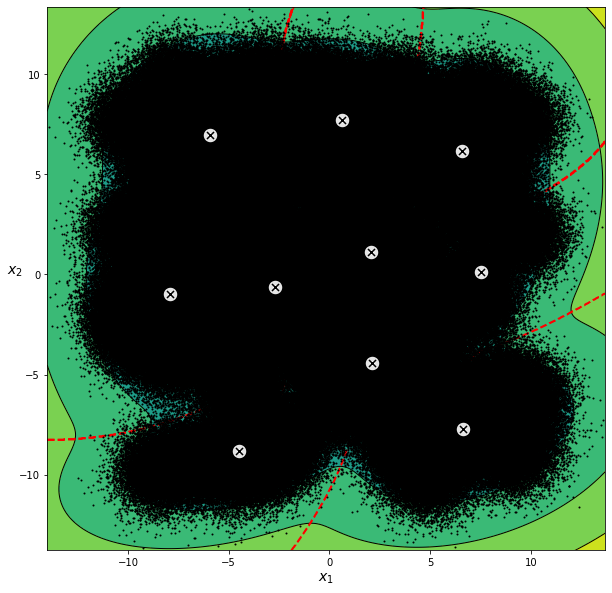

In [217]:
plt.figure(figsize=(10, 10))
plot_gaussian_mixture(gm, dsp_x_blob)
plt.show()

##Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(dsp_x_blob)
density_threshold = np.percentile(densities, 4)
anomalies = dsp_x_blob[densities < density_threshold]

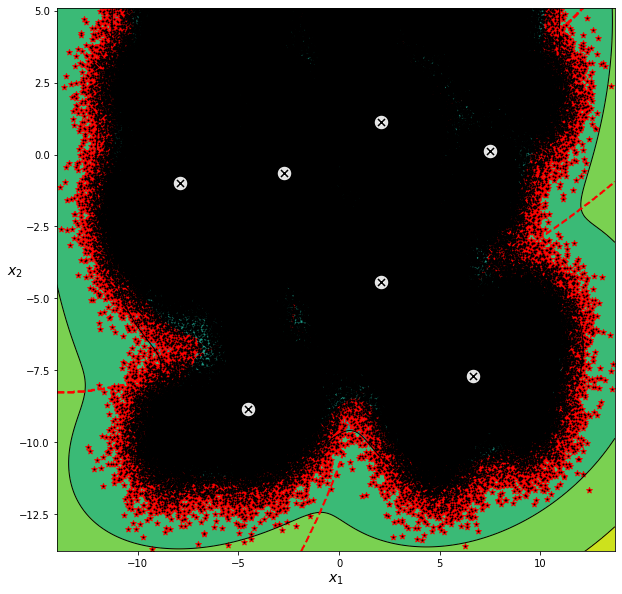

In [219]:
plt.figure(figsize=(10,10))

plot_gaussian_mixture(gm, dsp_x_blob)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Summary


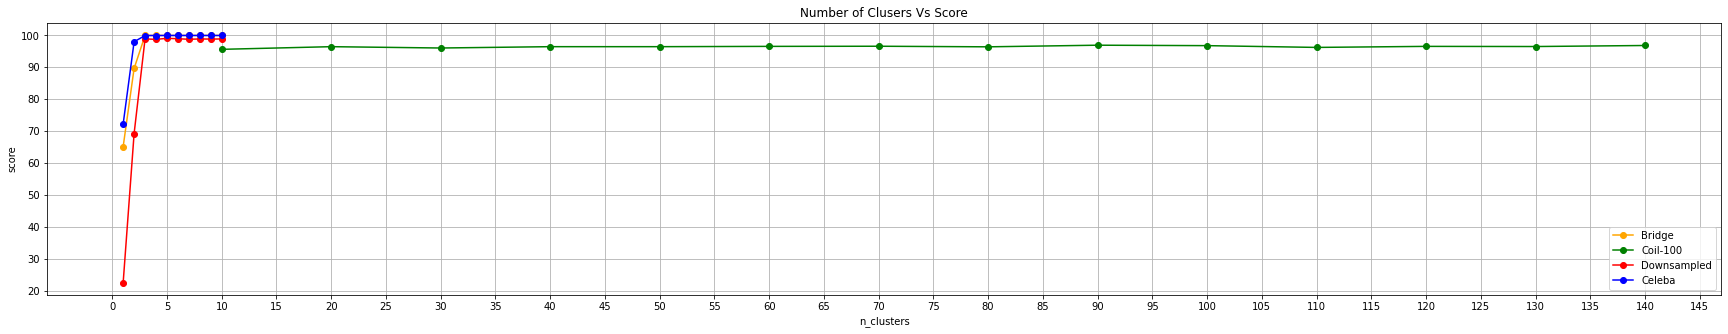

In [349]:
#Convert the list to a DataFrame to get each column separately
pipe_bridge_scores_df = pd.DataFrame(pipe_bridge_scores,columns=['n_cluster','score'])
pipe_bridge_n_clusters = pipe_bridge_scores_df['n_cluster']
pipe_bridge_scores_only = pipe_bridge_scores_df['score']

pipe_coil100_scores_df = pd.DataFrame(pipe_coil100_scores,columns=['n_cluster','score'])
pipe_coil100_n_clusters = pipe_coil100_scores_df['n_cluster']
pipe_coil100_scores_only = pipe_coil100_scores_df['score']

pipe_dsp_scores_df = pd.DataFrame(pipe_dsp_scores,columns=['n_cluster','score'])
pipe_dsp_n_clusters = pipe_dsp_scores_df['n_cluster']
pipe_dsp_scores_only = pipe_dsp_scores_df['score']

pipe_clb_scores_df = pd.DataFrame(pipe_clb_scores,columns=['n_cluster','score'])
pipe_clb_n_clusters = pipe_clb_scores_df['n_cluster']
pipe_clb_scores_only = pipe_clb_scores_df['score']

#Plot the chart
plt.figure(figsize=(30,5))
plt.plot(pipe_bridge_n_clusters,pipe_bridge_scores_only*100,'bo-',label='Bridge',color='orange')
plt.plot(pipe_coil100_n_clusters,pipe_coil100_scores_only*100,'bo-',label='Coil-100',color='green')
plt.plot(pipe_dsp_n_clusters,pipe_dsp_scores_only*100,'bo-',label='Downsampled',color='red')
plt.plot(pipe_clb_n_clusters,pipe_clb_scores_only*100,'bo-',label='Celeba')
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Number of Clusers Vs Score')
plt.xticks(range(0,150,5))
plt.legend()
plt.grid(True)
plt.show()